# Covermap Comparison

**Author:** Adam Yang (ayang115@umd.edu)

**Description:** Compares datasets against test sets

**Crop Maps Used:** Harvest Togo & Kenya, Copernicus Land Cover, ESA CCI Land Cover Africa, GLAD Global Cropland Extent

In [1]:
import os
import geemap
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio

from pathlib import Path
from shapely import wkt
from sklearn.metrics import classification_report 
from shapely.geometry import Point, MultiPolygon, GeometryCollection 


c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import ee

ee.Authenticate()

ee.Initialize()


Successfully saved authorization token.


### **Setup**

**Constants**

In [3]:
TEST_COUNTRIES = ["Kenya", "Togo", "Tanzania_CEO_2019"]
DATA_PATH = "../data/datasets/"
TEST_CODE = {"Kenya": "KEN", "Togo": "TGO", "Tanzania_CEO_2019": "TZA"} # for NE boundaries

In [4]:
DATASET_PATH = Path(DATA_PATH).glob("*")
TARGET_PATHS = [p for p in DATASET_PATH if p.stem in TEST_COUNTRIES] # test data path

In [5]:
# country boundaries
NE_GDF = gpd.read_file(
    shpreader.natural_earth(
        resolution='10m', 
        category='cultural', 
        name='admin_1_states_provinces')
)


**Functions**

In [6]:
# Remaps classes to crop/noncrop 
def map_values(val, value_for_crop):
    if val == value_for_crop:
        return 1
    else:
        return 0

In [36]:
# Function used in map function to extract from feature collection
def raster_extraction(image, resolution, f_collection):
    feature = image.sampleRegions(
        collection = f_collection,
        scale = resolution,
    )
    return feature

In [8]:
# Convert sklearn classification report dict to 
def generate_report(dataset, report):
    return pd.DataFrame(data = {
        "dataset": dataset, 
        "accuracy": report["accuracy"], 
        "crop_f1": report["1"]["f1-score"], 
        "crop_support": report["1"]["support"], 
        "noncrop_support": report["0"]["support"], 
        "crop_precision": report["1"]["precision"], 
        "crop_recall": report["1"]["recall"], 
        "noncrop_precision": report["0"]["precision"], 
        "noncrop_recall": report["0"]["recall"]
        }, index=[0])
    

In [9]:
# Creates ee.Feature from longitude and latitude coordinates from a dataframe
def create_point(row):
    geom = ee.Geometry.Point(row.lon, row.lat)
    prop = dict(row[['lon', 'lat', 'test_class']])

    return ee.Feature(geom, prop)

In [10]:
# filters out data in gdf that is not within country bounds 
def filter_by_bounds(country: str, gdf: gpd.GeoDataFrame):
    boundary = NE_GDF.loc[NE_GDF['adm1_code'].str.startswith(country), :].copy()

    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')

    boundary = GeometryCollection([x for x in boundary['geometry']])

    mask = gdf.within(boundary)
    filtered = gdf.loc[mask].copy()

    return filtered

### **Generate Test Data**

In [11]:
#create a testing geodataframe
def generate_test_data(target_paths: str):
    test_gdf = gpd.GeoDataFrame(
        columns=['lat', 'lon', 'country', 'test_class', 'geometry'], 
        crs = 'epsg:4326')

    test_set = []
    
    for p in target_paths:
        # Set dict key name
        key = p.stem

        # Read in data and extract test values and points 
        df = pd.read_csv(p)
        df = df.loc[df['subset']=='testing']
        df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs='epsg:4326')

        # binarize
        df['test_class'] = df['class_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

        df['country'] = key

        df = filter_by_bounds(TEST_CODE[key], df)

        test_set.append(df)

    return pd.concat(test_set)

In [12]:
# test_data = generate_test_data(TARGET_PATHS)

In [13]:
# test_data.to_csv('../../intercomparison-data/test_data.csv')

In [14]:
test_data = pd.read_csv("../../intercomparison-data/test_data.csv").drop("Unnamed: 0", axis=1)
test_data["geometry"] = test_data["geometry"].apply(wkt.loads)
test_data = gpd.GeoDataFrame(test_data, crs="epsg:4326")

In [15]:
test_data.head()

,lon,lat,start_date,end_date,source,class_probability,num_labelers,subset,analysis_duration,email,country,dataset,eo_data,eo_lon,eo_lat,eo_file,eo_status,geometry,test_class
0,34.386282,0.725122,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-11.74174313771244, -16.760872534791257, 952...",34.386296,0.725165,min_lat=0.7244_min_lon=34.3856_max_lat=0.7258_...,eo_data_complete,POINT (34.38628 0.72512),0
1,34.466496,0.621939,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-6.565833796243928, -12.449147022074829, 951...",34.466516,0.621949,min_lat=0.6212_min_lon=34.4658_max_lat=0.6227_...,eo_data_complete,POINT (34.46650 0.62194),0
2,34.054859,0.226497,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-9.902949034787321, -15.70680808103578, 1174...",34.054818,0.226510,min_lat=0.2258_min_lon=34.0541_max_lat=0.2272_...,eo_data_complete,POINT (34.05486 0.22650),0
3,33.951959,0.096834,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-14.47299462942356, -17.955564415668587, 106...",33.951961,0.096793,min_lat=0.0961_min_lon=33.9512_max_lat=0.0976_...,eo_data_complete,POINT (33.95196 0.09683),0
4,33.968469,0.032072,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-18.75145501670486, -28.983927974857025, 105...",33.968490,0.032115,min_lat=0.0313_min_lon=33.9678_max_lat=0.0328_...,eo_data_complete,POINT (33.96847 0.03207),0


### **Examine test set**

<AxesSubplot:>

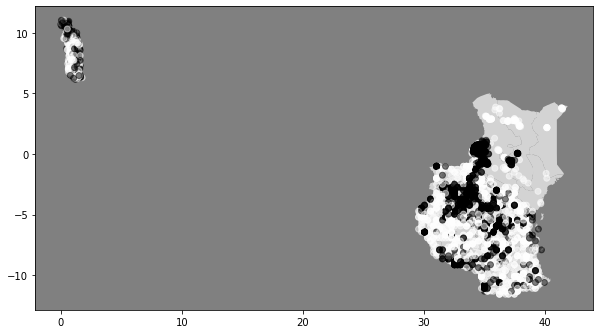

In [136]:
KEN_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("KEN")].copy()
TGO_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TGO")].copy()
TZA_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TZA")].copy()
masks = [KEN_mask, TZA_mask]

# Make sure the shapefile has EPSG:4326, otherwise convert it
for boundary in masks:
    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')
    boundary['roi'] = True
    boundary.reset_index(inplace=True, drop=True)
    boundary.dissolve('roi')

df = gpd.GeoDataFrame(pd.concat(masks)).set_crs('epsg:4326')

fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor("gray")
df["geometry"].to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
test_data.plot(ax=ax, column='test_class', alpha=0.5, cmap='binary')

Support for each country

In [137]:
print(
    len(test_data[test_data['country']=='Togo']), 
    len(test_data[test_data['country']=='Kenya']), 
    len(test_data[test_data['country']=='Tanzania_CEO_2019'])
    )

352 764 1537


Assert no overlap

In [138]:
tgo = test_data.loc[test_data['country']=='Togo'].copy()
ken = test_data.loc[test_data['country']=='Kenya'].copy()
tan = test_data.loc[test_data['country']=='Tanzania_CEO_2019'].copy()

In [139]:
assert ~ken.overlaps(tan).all(), "Overlap detected!"
assert ~tan.overlaps(ken).all(), "Overlap detected!"

### **Generate earth engine points**

In [19]:
togo_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Togo"].apply(create_point, axis=1).to_list())
kenya_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Kenya"].apply(create_point, axis=1).to_list())
tanz_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Tanzania_CEO_2019"].apply(create_point, axis=1).to_list())

# All countries
test_coll = ee.FeatureCollection(test_data.apply(create_point, axis=1).to_list())


### **Harvest Data**

In [195]:
HARVEST_PATHS = {
    "projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary" : togo_coll, 
    "projects/sat-io/open-datasets/nasa-harvest/kenya_cropland_binary" : kenya_coll,
    "users/adadebay/Tanzania_cropland_2019" : tanz_coll}

In [196]:
harvest = []
for map in HARVEST_PATHS.keys():
    name = map.split('/')[-1]
    print(name)

    #sample from earth engine
    sampled = ee.Image(map).reduceRegions(
        collection=HARVEST_PATHS[map],
        reducer=ee.Reducer.first()
    )
    
    #convert to dataframe
    sampled = geemap.ee_to_gdf(sampled)
    
    #binarize 
    sampled['first'] = sampled['first'].apply(lambda x: 1 if x>=0.5 else 0) 

    harvest.append(sampled)

harvest = pd.concat(harvest)

# harvest.to_csv('../../intercomparison-data/harvest.csv')

togo_cropland_binary
kenya_cropland_binary
Tanzania_cropland_2019


In [198]:
# Join test and sampled sets
test_data["harvest"] = pd.merge(test_data, harvest, on=["lat", "lon"], how="left")["first"]

### **COP, ESA, GLAD**

In [204]:
copernicus = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")
esa = ee.ImageCollection("ESA/WorldCover/v100")
glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019")

In [60]:
copernicus = copernicus.select("discrete_classification").filterDate("2019-01-01", "2020-01-01").map(lambda x: raster_extraction(x, 100, test_coll)).flatten()
cop_sampled = geemap.ee_to_gdf(copernicus)
cop_sampled["cop_class"] = cop_sampled["discrete_classification"].apply(lambda x: 1 if x==40 else 0)

esa = esa.filterBounds(test_coll).map(lambda x: raster_extraction(x, 10, test_coll)).flatten()
esa_sampled = geemap.ee_to_gdf(esa)
esa_sampled["esa_class"] = esa_sampled["Map"].apply(lambda x: 1 if x==40 else 0)

glad = glad.filterBounds(test_coll).map(lambda x: raster_extraction(x, 30, test_coll)).flatten()
glad_sampled = geemap.ee_to_gdf(glad)

In [59]:
test_data["cop"] = pd.merge(test_data, cop_sampled, on=["lat", "lon"], how="left")["cop_class"]
test_data["esa"] = pd.merge(test_data, esa_sampled, on=["lat", "lon"], how="left")["esa_class"]
test_data['glad'] = pd.merge(test_data, glad_sampled, on=["lat", "lon"], how="left")["b1"]

In [206]:
assert (np.sort(cop_sampled[['lat', 'lon']]) == np.sort(test_data[['lat','lon']])).all(), "Point mismatch!"
assert (np.sort(esa_sampled[['lat', 'lon']]) == np.sort(test_data[['lat','lon']])).all(), "Point mismatch!"

## **Evaluation Results**

**Compute results**

In [216]:
results = {}

for p in TARGET_PATHS:
    key = p.stem
    results[key] = pd.DataFrame(columns=["dataset", "accuracy", "crop_f1", "crop_support", "noncrop_support", 
        "crop_precision", "crop_recall", "noncrop_precision", "noncrop_recall"])


In [217]:
for country, df in test_data.groupby("country"):
    for dataset in ["harvest", "cop", "esa", "glad"]:
        print(country + ": " + dataset)
        # Remove na values
        temp = df[["test_class", dataset]].dropna()
        report = classification_report(temp["test_class"], temp[dataset], output_dict= True)     

        results[country] = pd.concat([results[country], generate_report(dataset, report)])

Kenya: harvest
Kenya: cop
Kenya: esa
Kenya: glad
Tanzania_CEO_2019: harvest
Tanzania_CEO_2019: cop
Tanzania_CEO_2019: esa
Tanzania_CEO_2019: glad
Togo: harvest
Togo: cop
Togo: esa
Togo: glad


**Togo**

In [218]:
results["Togo"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.772727,0.738562,152,200,0.733766,0.743421,0.803030,0.795
0,cop,0.693182,0.571429,152,200,0.720000,0.473684,0.682540,0.860
0,esa,0.738636,0.606838,152,200,0.865854,0.467105,0.700000,0.945
0,glad,0.704545,0.559322,152,200,0.785714,0.434211,0.679104,0.910


**Kenya**

In [219]:
results["Kenya"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.890052,0.922509,571,193,0.974659,0.875657,0.717131,0.932642
0,cop,0.908377,0.939446,571,193,0.928205,0.950963,0.843575,0.782383
0,esa,0.403141,0.341040,571,193,0.975207,0.206655,0.295490,0.984456
0,glad,0.839005,0.887259,571,193,0.930769,0.847636,0.643443,0.813472


**Tanzania**

In [220]:
results["Tanzania_CEO_2019"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.760573,0.708861,767,770,0.901408,0.584094,0.693269,0.936364
0,cop,0.783995,0.743431,767,770,0.912713,0.627119,0.716832,0.940260
0,esa,0.789850,0.742219,767,770,0.956790,0.606258,0.712655,0.972727
0,glad,0.776187,0.718494,767,770,0.964835,0.572360,0.696858,0.979221


## ***TESTING ZONE***

In [114]:
# Test points for togo
test = pd.read_csv("../data/datasets/Togo.csv")
test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat), crs='epsg:4326')
test = test.loc[test['subset']=='testing']
test['binary'] = test['class_probability'].apply(lambda x: 1 if x >= 0.5 else 0)


In [116]:
togo = ee.Image("projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary")
props = geemap.image_props(togo)
props

In [117]:
def create_point2(row):
    geom = ee.Geometry.Point(row.lon, row.lat)
    prop = dict(row[['binary']])

    return ee.Feature(geom, prop)

proj_coll = ee.FeatureCollection(test.apply(create_point2, axis=1).to_list())

Method: ee.Image.reduceRegions

In [118]:
reduced = togo.reduceRegions(
    proj_coll,
    reducer=ee.Reducer.first()
    )

In [119]:
reduced = geemap.ee_to_gdf(reduced)

In [120]:
res = generate_report('ee', classification_report(reduced['binary'], reduced['first'], output_dict=True))

In [121]:
res

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,ee,0.771831,0.736156,152,203,0.729032,0.743421,0.805,0.793103


Test Image Collection

In [40]:
copernicus = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")
esa = ee.ImageCollection("ESA/WorldCover/v100")
glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019")

In [41]:
# Function used in map function to extract from feature collection
def reduce_region(image, resolution, f_collection):
    feature = image.reduceRegions(
        collection = f_collection,
        scale = resolution,
        reducer=ee.Reducer.first(),
    )
    return feature

In [61]:
copernicus_reduced = copernicus_reduced.select("discrete_classification").filterDate("2019-01-01", "2020-01-01").map(lambda x: raster_extraction(x, 100, test_coll)).flatten()
cop_reduced = geemap.ee_to_gdf(copernicus_reduced)
cop_reduced["reduced"] = cop_reduced["discrete_classification"].apply(lambda x: 1 if x==40 else 0)

esa_reduced = esa_reduced.filterBounds(test_coll).map(lambda x: raster_extraction(x, 10, test_coll)).flatten()
esa_reduced = geemap.ee_to_gdf(esa_reduced)
esa_reduced["reduced"] = esa_reduced["Map"].apply(lambda x: 1 if x==40 else 0)

glad_reduced = glad_reduced.filterBounds(test_coll).map(lambda x: raster_extraction(x, 30, test_coll)).flatten()
glad_reduced = geemap.ee_to_gdf(glad_reduced)

AttributeError: 'Feature' object has no attribute 'reduceRegions'

In [43]:
reduced_gdf["cop_class"] = reduced_gdf["first"].apply(lambda x: 1 if x==40 else 0)
reduced_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    2653 non-null   geometry
 1   first       2653 non-null   int64   
 2   lat         2653 non-null   float64 
 3   lon         2653 non-null   float64 
 4   test_class  2653 non-null   int64   
 5   cop_class   2653 non-null   int64   
dtypes: float64(2), geometry(1), int64(3)
memory usage: 124.5 KB


In [47]:
sampled = esa.filterDate(
        "2019-01-01", "2020-01-01").map(
            lambda x: raster_extraction(x, 10, test_coll)).flatten()
        
sampled_gdf = geemap.ee_to_gdf(sampled)

In [49]:
sampled_gdf

""


In [48]:
sampled_gdf["cop_class"] = sampled_gdf["discrete_classification"].apply(lambda x: 1 if x==40 else 0)
sampled_gdf.info()

KeyError: 'discrete_classification'

In [ ]:
sampled_gdf['cop_class'].compare(reduced_gdf['cop_class'])

,self,other
